# Ressources

In [2]:
import pandas as pd
import numpy as np
import missingno

import plotly.graph_objects as go
from plotly.subplots import make_subplots

from pycaret.classification import *

# fix pour plotly express et Visual Studio Code
import plotly.io as pio
pio.renderers.default = "notebook_connected"

import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer


from imblearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer



# Garbage collection is to release memory when the object is no longer in use. This system destroys the unused object and reuses its memory slot for new objects. You can imagine this as a recycling system in computers.

import shap


from lightgbm import LGBMClassifier
import lightgbm as lgb
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold

from rich.console import Console

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#

# Question 1: I don't agree that we should combine the training and testing and then apply normalization or imputation. We should split the data, normalize the training set and apply what we have learned from training dataset on the testing dataset. Similarly, for imputation - we learn on the training and transform what we have learned on the dataset.
# Regarding your question about the imputation, you will notice that we often have three main methods while imputing the data in most of the libraries; fit_transform(), fit(), and transform(). Usually, you apply fit_transform() or fit() then transform() on the training data. Then, transform() is applied to the testing dataset. This is because you want to have a fair evaluation of the model. You transform what you have learned from training data. If you fit imputation on both training and testing, then any new testing dataset requires you to re-impute all data again, and this allows leaking information/feature into the model because the information from testing dataset is included in training the model, and consequently, your model won't be able to predict a new data. To this end, you apply the transform of imputation that has already fitted on the training dataset on the new/testing dataset as pre-processing and fairly test how the model can predict a new fresh dataset.

# Overall, make sure to calculate your metric (e.g. median, mean,.. ) only on the train data in order to avoid data leakage to your test data-set while imputing your data-set.


# Fonctions
## Data

In [3]:

def comparaisons_colonnes(df1:pd.DataFrame, df2:pd.DataFrame):
    """Compare les colonnes de deux DF, et renvoient celles qui ne sont pas présentes dans les deux fichiers.

    Parameters
    -----------
    df1: :class:`DataFrame`

    df2: :class:`DataFrame`

            
    Return
    ----------
    Deux listes avec la différence dans le DataFrame 1 puis le DataFrame 2
    
    Exemples
    ----------
    list_1 = list(df_2015.columns)
    
    list_2 = list(df_2016.columns)

    dif1, dif2 = comparaisons_colonnes(df1, df2)
    """
    
    list_1 = list(df1.columns)
    list_2 = list(df2.columns)
    # Un set est un ensemble de clefs non ordonnées et non redondant où l'on peut savoir
    # si un élément est présent sans avoir à parcourir toute la liste (une sorte de dictionnaire où les valeurs seraient ignorées, seules les clefs comptent).
    dif_list_1_list_2 = list(set(list_1) - set(list_2))
    dif_list_2_list_1 = list(set(list_2) - set(list_1))
    nb_dif_list1_list_2 = len(dif_list_1_list_2)
    nb_dif_list2_list1 = len(dif_list_2_list_1)
    print(f'Colonnes présentes dans le df1, absentes dans le df2 ({nb_dif_list1_list_2}) : {dif_list_1_list_2}')
    print(f'Colonnes présentes dans le df2, absentes dans le df1 ({nb_dif_list2_list1}) : {dif_list_2_list_1}')
    

    
def identification_colonne_binaire(df, var_ignore=None):
    
    df_identif = df.copy()
    if var_ignore != None:
        df_identif.drop([var_ignore], axis=1, inplace=True)
    nb_cols = df_identif.shape[1]
    col_binaire_name = []
    col_binaire_number = []
    for i in range(0, nb_cols):
        len_colonne = len(df_identif.iloc[:,i].value_counts())
        
        if len_colonne == 2:
            col_binaire_name.append(df_identif.iloc[:,i].name)
            col_binaire_number.append(i)
            
            
            
    print(f'Colonnes binaires : {col_binaire_name}')
    print(f'Nombres : {len(col_binaire_number)}')
    
    return col_binaire_name, col_binaire_number


def identification_colonne_categorique(df, var_ignore=None, nb_valeurs_unique=2):
    
    df_identif = df.copy()
    if var_ignore != None:
        df_identif.drop([var_ignore], axis=1, inplace=True)
    nb_cols = df_identif.shape[1]
    col_binaire_name = []
    col_binaire_number = []
    for i in range(0, nb_cols):
        len_colonne = len(df_identif.iloc[:,i].value_counts())
        
        if nb_valeurs_unique == 2:
            if len_colonne == nb_valeurs_unique:
                col_binaire_name.append(df_identif.iloc[:,i].name)
                col_binaire_number.append(i)
                df_identif.iloc[:,i] = df_identif.iloc[:,i].astype('object')
        else:
            if len_colonne <= nb_valeurs_unique:
                col_binaire_name.append(df_identif.iloc[:,i].name)
                col_binaire_number.append(i)
                df_identif.iloc[:,i] = df_identif.iloc[:,i].astype('object')
            
            
    if var_ignore != None:
        df_identif[var_ignore] = df[var_ignore]
            
            
            
    print(f'Colonnes binaires : {col_binaire_name}')
    print(f'Nombres : {len(col_binaire_number)}')
    
    return df_identif


def distribution_target(train_df_test):
    distrib_target = train_df_test['TARGET'].value_counts()  / len(train_df_test['TARGET'])*100


    # fig = px.histogram(train_df_test, x="TARGET", color="TARGET", text_auto=True)

    # fig.show()

    fig = make_subplots(rows=1, cols=2, subplot_titles=("Distribution", "Répartition"),
                            specs=[[{"type": "xy"}, {"type": "domain"}]])

    cat0 = train_df_test[train_df_test['TARGET']==0]['TARGET']
    cat1 = train_df_test[train_df_test['TARGET']==1]['TARGET']

    # fig.add_trace(go.Histogram(x=train_df_test['TARGET']), row=1, col=1)
    fig.add_trace(go.Histogram(x=cat0, name="0", text=str(cat0.count())), row=1, col=1)
    fig.add_trace(go.Histogram(x=cat1, name="1", text=str(cat1.count())), row=1, col=1)
    fig.add_trace(go.Pie(values=distrib_target.values), row=1, col=2)


    fig.update_layout(height=500, showlegend=False, title_text="TARGET")

    #x axis    
    fig.update_xaxes(visible=False)

    fig.show()

### Corrélation

In [4]:
def correlation_independante_et_dependante(df:pd.DataFrame, colonne:str, title:str):
        
        """Corrélation entre des variables indépendantes avec une variable dépendante.
        Renvoie une heatmap en une seule colonne

    Parameters
    -----------
    df: :class:`DataFrame`
            Le DataFrame
    colonne: :class:`str`
            La variable dépendante, où on va juger les corrélations des autres variables
    title: :class:`str`
            Titre du graphique
            
    Return
    ----------
    Graphique
    """
        
        f, ax = plt.subplots(figsize=(11, 20))

        heatmap = sns.heatmap(df.corr()[[colonne]].sort_values(by=colonne, ascending=False), annot=True)
        
        heatmap.set_title(title, fontdict={'fontsize':18}, pad=16);

In [5]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.pipeline import Pipeline
        

from rich.console import Console

def lightbgm(train_df, test_df, num_folds=10, stratified=False):
    console = Console()
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=1001)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=1001)
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0]) # créer une array remplie de 0 qui aura les mêmes dimensions que le df
    sub_preds = np.zeros(test_df.shape[0]) # créer une array remplie de 0 qui aura les mêmes dimensions que le df
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']] # variables du DF qui ne sont pas dans la liste (Target est la variable à prédire, les autres n'ont pas d'impact sur la prédiction)
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

        # LightGBM parameters found by Bayesian optimization
        clf = LGBMClassifier(
            # nthread=8,
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1,
            device="cpu",
            n_jobs=-1)

        clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
            eval_metric= 'auc', verbose= 200, early_stopping_rounds= 200)

        # predit proba est utilisé pour prédire les possibilités de classe.
        # predit proba = % que la proba soit égale à 1 car [:,1]. Si on ne met rien, on a la proba pour 0 et 1.
        oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits # Retourne la probabilité prédite pour chaque classe pour chaque échantillon. Division pour faire la moyenne entre les folds

        
        # console.print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])), style="green")
        
    console.print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds), style="green")
        
        
    test_df['TARGET'] = sub_preds
    test_df[['SK_ID_CURR', 'TARGET']].to_csv('submission_kevin.csv', index= False)
    
    return clf, train_df, test_df, feats

In [34]:
from imblearn.pipeline import Pipeline, make_pipeline
# def auc_smoke(df, model, cv=None):
#     """
#     Creates folds manually, and upsamples within each fold.
#     Returns an array of validation (recall) scores
#     """
#     if cv is None:
#         cv = KFold(n_splits=5, random_state=42, shuffle=True)
        
#     X = df.drop(['TARGET'], axis=1)
#     y = df['TARGET']   
        
#     X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=45)

#     smoter = SMOTE(random_state=42)
    
#     scores = []

#     for train_fold_index, val_fold_index in cv.split(X_train, y_train):
#         # Get the training data
#         X_train_fold, y_train_fold = X_train.iloc[train_fold_index], y_train[train_fold_index]
#         # Get the validation data
#         X_val_fold, y_val_fold = X_train.iloc[val_fold_index], y_train[val_fold_index]

#         # Upsample only the data in the training section
#         X_train_fold_upsample, y_train_fold_upsample = smoter.fit_resample(X_train_fold,
#                                                                            y_train_fold)
#         # Fit the model on the upsampled training data
#         model_obj = model.fit(X_train_fold_upsample, y_train_fold_upsample)
#         # Score the model on the (non-upsampled) validation data
#         score = roc_auc_score(y_val_fold, model_obj.predict_proba(X_val_fold)[:, 1])
#         scores.append(score)
#     return np.array(scores)

      
def auc_smoke(df, model, impute="SimpleImputer", etape="before", cv=None):
    # https://kiwidamien.github.io/how-to-do-cross-validation-when-upsampling-data.html
    
    if cv is None:
        # kf = KFold(n_splits=5, random_state=42, shuffle=True)
        kf = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
        
        
    X = df.drop(['TARGET'], axis=1)
    y = df['TARGET']
    
    # using the median is OK if your distribution is not normal, because the median is not influenced by the outliers. 
    # If your distribution is close to normal, you may use mean as a better representative.
    
    
    if impute == "SimpleImputer":   
        imp = SimpleImputer(missing_values = np.nan, strategy="median")
        
    
    elif impute == "Iterative":
        imp = IterativeImputer(missing_values = np.nan, random_state=0)
        
        
    if etape=="before" and impute is not None:    
        

        columns = X.columns

        X = pd.DataFrame(imp.fit_transform(df[columns]), columns=columns)
            
        
        
        imb = make_pipeline(SMOTE(random_state=42), model)
        
        
    elif etape=="after":
        imb = make_pipeline(imp, SMOTE(random_state=42), model)
        
    
    if impute is None:
        imb = make_pipeline(SMOTE(random_state=42), model)
    

    score = cross_val_score(imb, X, y, scoring="roc_auc", cv=kf, n_jobs=-1)


    print(f"Total : {score.mean()}")


    
    
    
    

def auc_smoke_best_params(df, model, params, cv=None):
    # https://kiwidamien.github.io/how-to-do-cross-validation-when-upsampling-data.html
    if cv is None:
        kf = KFold(n_splits=5, random_state=42, shuffle=True)
        
    X = df.drop(['TARGET'], axis=1)
    y = df['TARGET']   
        
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
    
    new_params = {'lgbmclassifier__' + key: params[key] for key in params} # à modifier par le nom du model
    
    imb = make_pipeline(SMOTE(random_state=42), model)
    
    grid_imb = GridSearchCV(imb, param_grid=new_params, cv=kf, scoring="roc_auc", verbose=1, return_train_score=True, n_jobs=-1)
    
    grid_imb.fit(X_train, y_train)
    
    print(grid_imb.best_score_)
    print(grid_imb.best_params_)
    
    auc_test = roc_auc_score(y_test, grid_imb.predict_proba(X_test)[:,1])
    
    print(auc_test)
    
    return grid_imb
    
    
def auc_smoke_best_params_imp(df, model, params, cv=None):
    # https://kiwidamien.github.io/how-to-do-cross-validation-when-upsampling-data.html
    if cv is None:
        kf = KFold(n_splits=5, random_state=42, shuffle=True)
        
    X = df.drop(['TARGET'], axis=1)
    y = df['TARGET']   
        
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
    
    imp = IterativeImputer(missing_values = np.nan, random_state=0)
    
    new_params = {'lgbmclassifier__' + key: params[key] for key in params} # à modifier par le nom du model
    
    imb = make_pipeline(imp, SMOTE(random_state=42), model)
    
    grid_imb = GridSearchCV(imb, param_grid=new_params, cv=kf, scoring="roc_auc", verbose=1, return_train_score=True, n_jobs=-1)
    
    grid_imb.fit(X_train, y_train)
    
    print(grid_imb.best_score_)
    print(grid_imb.best_params_)
    
    auc_test = roc_auc_score(y_test, grid_imb.predict_proba(X_test)[:,1])
    
    print(auc_test)
    
    return grid_imb
    


clf = LGBMClassifier(
            # nthread=8,
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1,
            device="cpu",
            n_jobs=-1)

# Data formatée

In [7]:
# fichier application_test avec uniquement l'id et Target

data_test_clean = pd.read_csv('submission_kernel02.csv')
data_test_clean.rename(columns={'TARGET' : 'PROBA_TARGET'}, inplace=True)
data_test_clean

# Target = La probabilité prédite pour chaque classe pour chaque échantillon. Pourquoi dans un dataset séparé ?

,SK_ID_CURR,PROBA_TARGET
0,100001,0.034300
1,100005,0.146855
2,100013,0.027505
3,100028,0.038554
4,100038,0.153569
...,...,...
48739,456221,0.046247
48740,456222,0.060781
48741,456223,0.008308
48742,456224,0.026186


In [8]:
# Fichier application_train fusionnée
data_results = pd.read_csv('data_featured.csv')


In [9]:
data_results

,index,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
0,0,100002,1.0,0,0,0,0,202500.0,406597.5,24700.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,100003,0.0,1,0,1,0,270000.0,1293502.5,35698.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,100004,0.0,0,1,0,0,67500.0,135000.0,6750.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,100006,0.0,1,0,0,0,135000.0,312682.5,29686.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
4,4,100007,0.0,0,0,0,0,121500.0,513000.0,21865.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356246,48739,456221,NaN,1,0,0,0,121500.0,412560.0,17473.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
356247,48740,456222,NaN,1,0,1,2,157500.0,622413.0,31909.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
356248,48741,456223,NaN,1,1,0,1,202500.0,315000.0,33205.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
356249,48742,456224,NaN,0,0,1,0,225000.0,450000.0,25128.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Selection des features -> Imputer -> Smote

In [10]:
df_importance = pd.read_csv('feature_importance_avg.csv')
df_importance

,feature,importance,importance_normalized,cumulative_importance
0,PAYMENT_RATE,1128.6,0.071755,0.071755
1,EXT_SOURCE_1,1005.5,0.063928,0.135683
2,EXT_SOURCE_3,960.6,0.061073,0.196756
3,EXT_SOURCE_2,913.9,0.058104,0.254861
4,DAYS_BIRTH,718.4,0.045675,0.300535
5,AMT_ANNUITY,537.4,0.034167,0.334702
6,DAYS_EMPLOYED,510.9,0.032482,0.367185
7,APPROVED_CNT_PAYMENT_MEAN,432.5,0.027498,0.394682
8,DAYS_ID_PUBLISH,431.5,0.027434,0.422116
9,INCOME_CREDIT_PERC,415.3,0.026404,0.448521


# Selection features

On va selectionner selon le feature importance

In [11]:
cols = df_importance.sort_values(by=["importance"], ascending=False)['feature'].unique()[:20]
data_features = data_results[cols]

data_features['SK_ID_CURR'] = data_results['SK_ID_CURR']
data_features['TARGET'] = data_results['TARGET']

data_features

,PAYMENT_RATE,EXT_SOURCE_1,EXT_SOURCE_3,EXT_SOURCE_2,DAYS_BIRTH,AMT_ANNUITY,DAYS_EMPLOYED,APPROVED_CNT_PAYMENT_MEAN,DAYS_ID_PUBLISH,INCOME_CREDIT_PERC,...,INSTAL_DPD_MEAN,DAYS_REGISTRATION,DAYS_EMPLOYED_PERC,ACTIVE_DAYS_CREDIT_ENDDATE_MIN,AMT_CREDIT,PREV_CNT_PAYMENT_MEAN,AMT_GOODS_PRICE,INSTAL_AMT_PAYMENT_SUM,SK_ID_CURR,TARGET
0,0.060749,0.083037,0.139376,0.262949,9461,24700.5,-637.0,24.000000,-2120,0.121978,...,0.000000,-3648.0,0.067329,780.0,406597.5,24.000000,351000.0,219625.695,100002,1.0
1,0.027598,0.311267,NaN,0.622246,16765,35698.5,-1188.0,10.000000,-291,0.132217,...,0.000000,-1186.0,0.070862,1216.0,1293502.5,10.000000,1129500.0,1618864.650,100003,0.0
2,0.050000,NaN,0.729567,0.555912,19046,6750.0,-225.0,4.000000,-2531,0.100000,...,0.000000,-4260.0,0.011814,NaN,135000.0,4.000000,135000.0,21288.465,100004,0.0
3,0.094941,NaN,NaN,0.650442,19005,29686.5,-3039.0,18.000000,-2437,0.219900,...,0.000000,-9833.0,0.159905,NaN,312682.5,23.000000,297000.0,1007153.415,100006,0.0
4,0.042623,NaN,NaN,0.322738,19932,21865.5,-3038.0,20.666667,-3458,0.179963,...,0.954545,-4311.0,0.152418,NaN,513000.0,20.666667,513000.0,806127.975,100007,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356246,0.042354,NaN,0.643026,0.648575,19970,17473.5,-5169.0,24.000000,-3399,0.143815,...,0.000000,-9094.0,0.258838,495.0,412560.0,24.000000,270000.0,273109.365,456221,NaN
356247,0.051267,NaN,NaN,0.684596,11186,31909.5,-1149.0,17.500000,-3003,0.202600,...,0.520548,-3015.0,0.102718,NaN,622413.0,17.500000,495000.0,567315.675,456222,NaN
356248,0.105414,0.733503,0.283712,0.632770,15922,33205.5,-3037.0,11.000000,-1504,0.163978,...,0.000000,-2681.0,0.190742,NaN,315000.0,11.000000,315000.0,185271.930,456223,NaN
356249,0.055840,0.373090,0.595456,0.445701,13968,25128.0,-2731.0,17.000000,-1364,0.111680,...,0.034483,-1461.0,0.195518,-2.0,450000.0,14.500000,450000.0,500807.790,456224,NaN


In [12]:
data_features_train = data_features[data_features['TARGET'].notnull()] # Target présent
data_features_train.drop(['SK_ID_CURR'], axis=1, inplace=True)
data_features_test = data_features[data_features['TARGET'].isnull()] # Target NA

print(f"Train : {data_features_train.shape}")
print(f"Test : {data_features_test.shape}")

Train : (307507, 21)
Test : (48744, 22)


# Variable TARGET

## Distribution

In [13]:
distribution_target(data_features_train)

Il faudra donc penser à équilibrer le dataset

## Corrélation

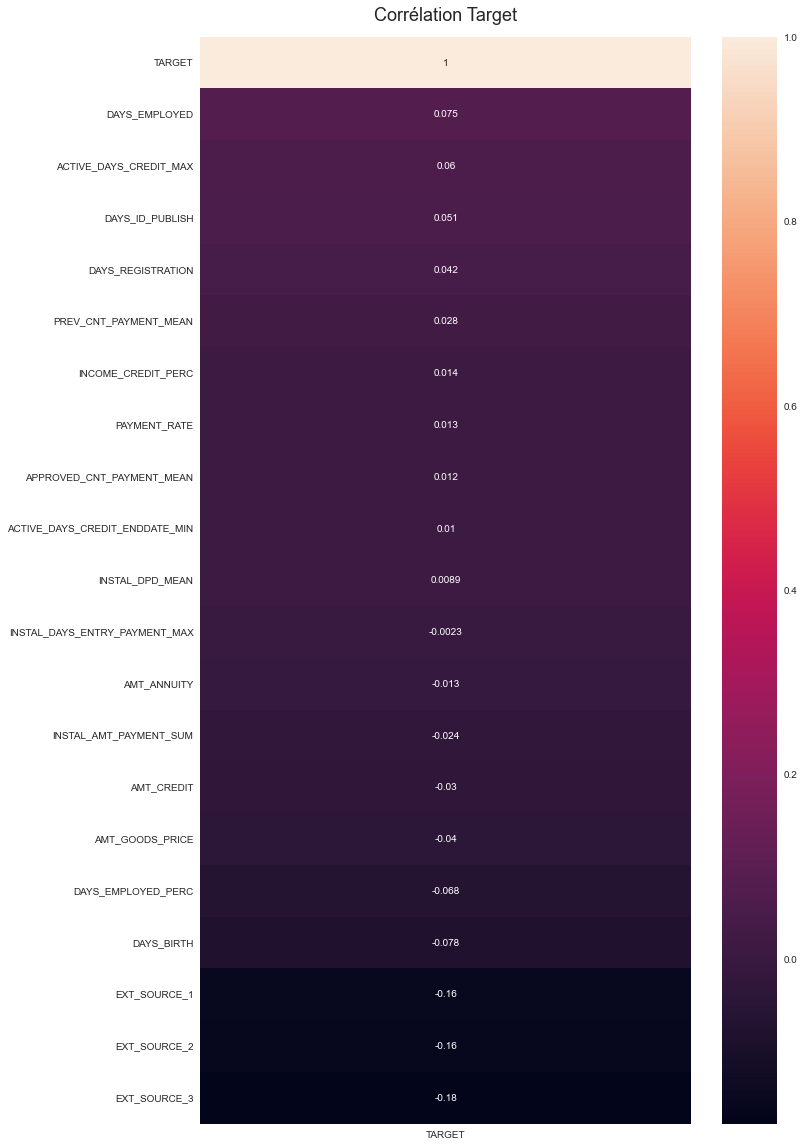

In [14]:
correlation_independante_et_dependante(data_features_train, "TARGET", "Corrélation Target")

# Imputation des valeurs nulles

<AxesSubplot:>

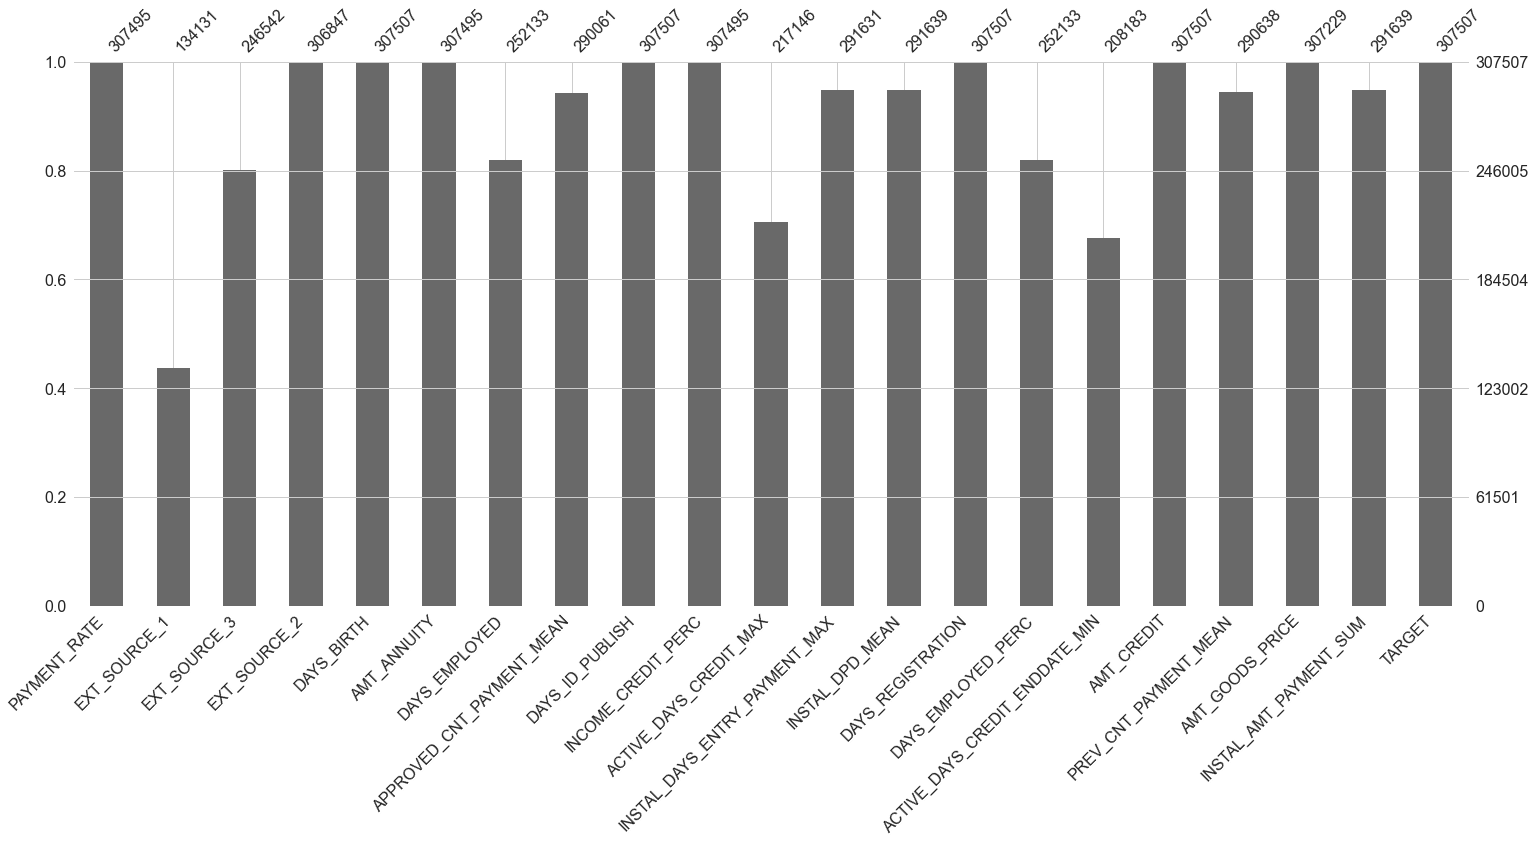

In [15]:
missingno.bar(data_features_train)

## fillna

In [16]:
data_features_na = data_features_train.fillna(0)

In [17]:
clf, train_df, test_df, feat = lightbgm(data_features_na, data_features_test, 2)

[200]	training's auc: 0.7831	training's binary_logloss: 0.239814	valid_1's auc: 0.760047	valid_1's binary_logloss: 0.246406
[400]	training's auc: 0.803446	training's binary_logloss: 0.232155	valid_1's auc: 0.766007	valid_1's binary_logloss: 0.244047
[600]	training's auc: 0.816544	training's binary_logloss: 0.227385	valid_1's auc: 0.767209	valid_1's binary_logloss: 0.243626
[800]	training's auc: 0.826911	training's binary_logloss: 0.223529	valid_1's auc: 0.767512	valid_1's binary_logloss: 0.243515
[1000]	training's auc: 0.83648	training's binary_logloss: 0.219929	valid_1's auc: 0.767401	valid_1's binary_logloss: 0.243563
[200]	training's auc: 0.785461	training's binary_logloss: 0.238916	valid_1's auc: 0.758075	valid_1's binary_logloss: 0.246646
[400]	training's auc: 0.804569	training's binary_logloss: 0.231561	valid_1's auc: 0.764087	valid_1's binary_logloss: 0.244483
[600]	training's auc: 0.817852	training's binary_logloss: 0.226734	valid_1's auc: 0.765789	valid_1's binary_logloss: 0.2

Full AUC score 0.767072

## Avec SimpleImputer

In [18]:
imp_mean = SimpleImputer(missing_values = np.nan, strategy="mean")


columns = data_features_train.columns

data_features_train_simp = pd.DataFrame(imp_mean.fit_transform(data_features_train[columns]))
data_features_train_simp.columns = columns
data_features_train_simp

,PAYMENT_RATE,EXT_SOURCE_1,EXT_SOURCE_3,EXT_SOURCE_2,DAYS_BIRTH,AMT_ANNUITY,DAYS_EMPLOYED,APPROVED_CNT_PAYMENT_MEAN,DAYS_ID_PUBLISH,INCOME_CREDIT_PERC,...,INSTAL_DAYS_ENTRY_PAYMENT_MAX,INSTAL_DPD_MEAN,DAYS_REGISTRATION,DAYS_EMPLOYED_PERC,ACTIVE_DAYS_CREDIT_ENDDATE_MIN,AMT_CREDIT,PREV_CNT_PAYMENT_MEAN,AMT_GOODS_PRICE,INSTAL_AMT_PAYMENT_SUM,TARGET
0,0.060749,0.083037,0.139376,0.262949,9461.0,24700.5,-637.000000,24.000000,-2120.0,0.121978,...,-49.0,0.000000,-3648.0,0.067329,780.000000,406597.5,24.000000,351000.0,219625.695,1.0
1,0.027598,0.311267,0.510856,0.622246,16765.0,35698.5,-1188.000000,10.000000,-291.0,0.132217,...,-544.0,0.000000,-1186.0,0.070862,1216.000000,1293502.5,10.000000,1129500.0,1618864.650,0.0
2,0.050000,0.502129,0.729567,0.555912,19046.0,6750.0,-225.000000,4.000000,-2531.0,0.100000,...,-727.0,0.000000,-4260.0,0.011814,1011.923265,135000.0,4.000000,135000.0,21288.465,0.0
3,0.094941,0.502129,0.510856,0.650442,19005.0,29686.5,-3039.000000,18.000000,-2437.0,0.219900,...,-12.0,0.000000,-9833.0,0.159905,1011.923265,312682.5,23.000000,297000.0,1007153.415,0.0
4,0.042623,0.502129,0.510856,0.322738,19932.0,21865.5,-3038.000000,20.666667,-3458.0,0.179963,...,-14.0,0.954545,-4311.0,0.152418,1011.923265,513000.0,20.666667,513000.0,806127.975,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307502,0.108198,0.145570,0.510856,0.681632,9327.0,27558.0,-236.000000,8.000000,-1982.0,0.174971,...,-38.0,0.000000,-8456.0,0.025303,1011.923265,254700.0,8.000000,225000.0,52450.470,0.0
307503,0.044524,0.502129,0.510856,0.115992,20775.0,12001.5,-2384.142254,6.000000,-4090.0,0.166687,...,-2327.0,0.500000,-4388.0,0.156860,1011.923265,269550.0,6.000000,225000.0,60419.205,0.0
307504,0.044239,0.744026,0.218859,0.535722,14966.0,29979.0,-7921.000000,5.000000,-5150.0,0.195941,...,-1738.0,0.642857,-6737.0,0.529266,387.000000,677664.0,5.000000,585000.0,57622.815,0.0
307505,0.054592,0.502129,0.661024,0.514163,11961.0,20205.0,-4786.000000,15.000000,-931.0,0.118158,...,-18.0,0.000000,-2562.0,0.400134,1011.923265,370107.0,15.000000,319500.0,194556.825,1.0


In [19]:
clf, train_df, test_df, feat = lightbgm(data_features_train_simp, data_features_test, 2)

[200]	training's auc: 0.782536	training's binary_logloss: 0.239556	valid_1's auc: 0.759113	valid_1's binary_logloss: 0.246459
[400]	training's auc: 0.802299	training's binary_logloss: 0.232115	valid_1's auc: 0.765158	valid_1's binary_logloss: 0.244287
[600]	training's auc: 0.81481	training's binary_logloss: 0.2276	valid_1's auc: 0.766575	valid_1's binary_logloss: 0.24384
[800]	training's auc: 0.825634	training's binary_logloss: 0.223661	valid_1's auc: 0.767223	valid_1's binary_logloss: 0.243692
[1000]	training's auc: 0.835449	training's binary_logloss: 0.220029	valid_1's auc: 0.766701	valid_1's binary_logloss: 0.24385
[200]	training's auc: 0.784302	training's binary_logloss: 0.239022	valid_1's auc: 0.757923	valid_1's binary_logloss: 0.246543
[400]	training's auc: 0.802553	training's binary_logloss: 0.232002	valid_1's auc: 0.764351	valid_1's binary_logloss: 0.244348
[600]	training's auc: 0.815233	training's binary_logloss: 0.227405	valid_1's auc: 0.766155	valid_1's binary_logloss: 0.243

Full AUC score 0.767030

In [20]:
auc_smoke(data_features_train, clf)

Total : 0.7104763486418848


In [21]:
auc_smoke(data_features_train, clf, etape="after")

Total : 0.7101905098332895


In [22]:
auc_smoke(data_features_train_simp, clf, impute=None)

Total : 0.7114857731226747


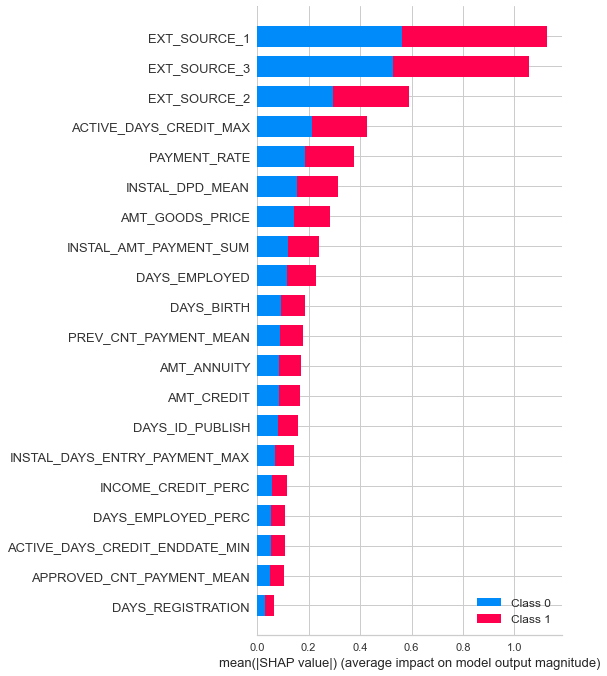

In [23]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(test_df[feat])
    
shap.summary_plot(shap_values, test_df[feat], feature_names=feat, max_display=20, show=False)

plt.savefig('./img/explain_shape.png')
plt.show()

## Avec IterativeImputer

In [24]:
# On impute les nan
imp_mean = IterativeImputer(missing_values = np.nan, random_state=0)


columns = data_features_train.columns

data_features_train_imp = pd.DataFrame(imp_mean.fit_transform(data_features_train[columns]))
data_features_train_imp.columns = columns
data_features_train_imp

,PAYMENT_RATE,EXT_SOURCE_1,EXT_SOURCE_3,EXT_SOURCE_2,DAYS_BIRTH,AMT_ANNUITY,DAYS_EMPLOYED,APPROVED_CNT_PAYMENT_MEAN,DAYS_ID_PUBLISH,INCOME_CREDIT_PERC,...,INSTAL_DAYS_ENTRY_PAYMENT_MAX,INSTAL_DPD_MEAN,DAYS_REGISTRATION,DAYS_EMPLOYED_PERC,ACTIVE_DAYS_CREDIT_ENDDATE_MIN,AMT_CREDIT,PREV_CNT_PAYMENT_MEAN,AMT_GOODS_PRICE,INSTAL_AMT_PAYMENT_SUM,TARGET
0,0.060749,0.083037,0.139376,0.262949,9461.0,24700.5,-637.000000,24.000000,-2120.0,0.121978,...,-49.0,0.000000,-3648.0,0.067329,780.000000,406597.5,24.000000,351000.0,219625.695,1.0
1,0.027598,0.311267,0.472312,0.622246,16765.0,35698.5,-1188.000000,10.000000,-291.0,0.132217,...,-544.0,0.000000,-1186.0,0.070862,1216.000000,1293502.5,10.000000,1129500.0,1618864.650,0.0
2,0.050000,0.634060,0.729567,0.555912,19046.0,6750.0,-225.000000,4.000000,-2531.0,0.100000,...,-727.0,0.000000,-4260.0,0.011814,998.000756,135000.0,4.000000,135000.0,21288.465,0.0
3,0.094941,0.647528,0.546727,0.650442,19005.0,29686.5,-3039.000000,18.000000,-2437.0,0.219900,...,-12.0,0.000000,-9833.0,0.159905,1028.342010,312682.5,23.000000,297000.0,1007153.415,0.0
4,0.042623,0.640783,0.531673,0.322738,19932.0,21865.5,-3038.000000,20.666667,-3458.0,0.179963,...,-14.0,0.954545,-4311.0,0.152418,649.051147,513000.0,20.666667,513000.0,806127.975,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307502,0.108198,0.145570,0.436392,0.681632,9327.0,27558.0,-236.000000,8.000000,-1982.0,0.174971,...,-38.0,0.000000,-8456.0,0.025303,2094.881898,254700.0,8.000000,225000.0,52450.470,0.0
307503,0.044524,0.621287,0.558824,0.115992,20775.0,12001.5,-3345.091228,6.000000,-4090.0,0.166687,...,-2327.0,0.500000,-4388.0,0.164994,103.617795,269550.0,6.000000,225000.0,60419.205,0.0
307504,0.044239,0.744026,0.218859,0.535722,14966.0,29979.0,-7921.000000,5.000000,-5150.0,0.195941,...,-1738.0,0.642857,-6737.0,0.529266,387.000000,677664.0,5.000000,585000.0,57622.815,0.0
307505,0.054592,0.379708,0.661024,0.514163,11961.0,20205.0,-4786.000000,15.000000,-931.0,0.118158,...,-18.0,0.000000,-2562.0,0.400134,1555.362258,370107.0,15.000000,319500.0,194556.825,1.0


In [25]:
clf, train_df, test_df, feat = lightbgm(data_features_train_imp, data_features_test, 2)

[200]	training's auc: 0.888064	training's binary_logloss: 0.191243	valid_1's auc: 0.875679	valid_1's binary_logloss: 0.197054
[400]	training's auc: 0.904869	training's binary_logloss: 0.17846	valid_1's auc: 0.885628	valid_1's binary_logloss: 0.188616
[600]	training's auc: 0.915477	training's binary_logloss: 0.170606	valid_1's auc: 0.89044	valid_1's binary_logloss: 0.184656
[800]	training's auc: 0.922514	training's binary_logloss: 0.165132	valid_1's auc: 0.892977	valid_1's binary_logloss: 0.182423
[1000]	training's auc: 0.929053	training's binary_logloss: 0.159801	valid_1's auc: 0.895137	valid_1's binary_logloss: 0.180481
[1200]	training's auc: 0.934936	training's binary_logloss: 0.154568	valid_1's auc: 0.897734	valid_1's binary_logloss: 0.17819
[1400]	training's auc: 0.939381	training's binary_logloss: 0.150667	valid_1's auc: 0.898672	valid_1's binary_logloss: 0.177196
[1600]	training's auc: 0.943443	training's binary_logloss: 0.147115	valid_1's auc: 0.899117	valid_1's binary_logloss: 

Full AUC score 0.903750

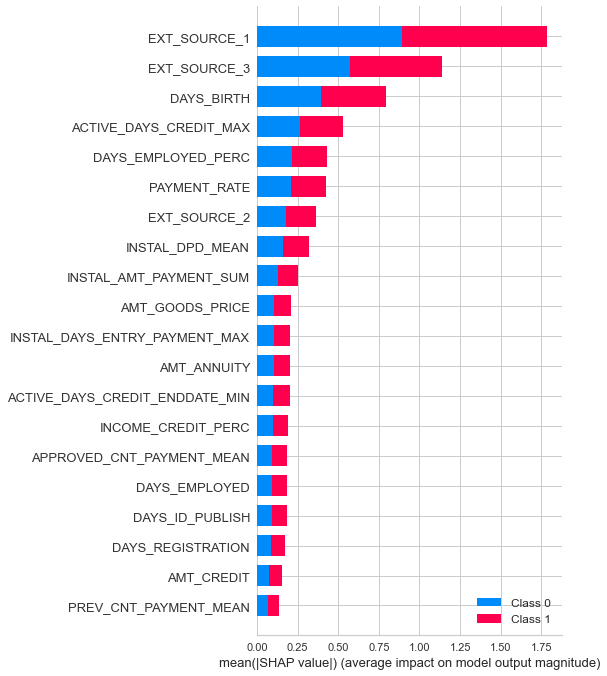

In [26]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(test_df[feat])
    
shap.summary_plot(shap_values, test_df[feat], feature_names=feat, max_display=20, show=False)

plt.savefig('./img/explain_shape.png')
plt.show()

In [27]:
auc_smoke(data_features_train, clf, impute="Iterative")

Total : 0.7083849778425272


In [28]:
auc_smoke(data_features_train, clf, impute="Iterative", etape="after")

Total : 0.7091007910646234


In [29]:
auc_smoke(data_features_train_imp, clf, impute=None)

Total : 0.882343791114241


In [36]:
param_grid = {
    'num_leaves': [120, 127],
    'reg_alpha': [0.3, 0.5]}


grid_imb = auc_smoke_best_params(data_features_train_imp, clf, param_grid)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
0.8801799977659535
{'lgbmclassifier__num_leaves': 127, 'lgbmclassifier__reg_alpha': 0.5}
0.8862957193130392


In [37]:
feat = [f for f in data_features_train_imp.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']] # variables du DF qui ne sont pas dans la liste (Target est la variable à prédire, les autres n'ont pas d'impact sur la prédiction)

In [49]:
sub_preds = np.zeros(data_features_test.shape[0])

sub_preds = grid_imb.predict_proba(data_features_test[feat])[:, 1] # Retourne la probabilité prédite pour chaque classe pour chaque échantillon. # Pourquoi diviser ?
                
data_features_test['TARGET'] = sub_preds

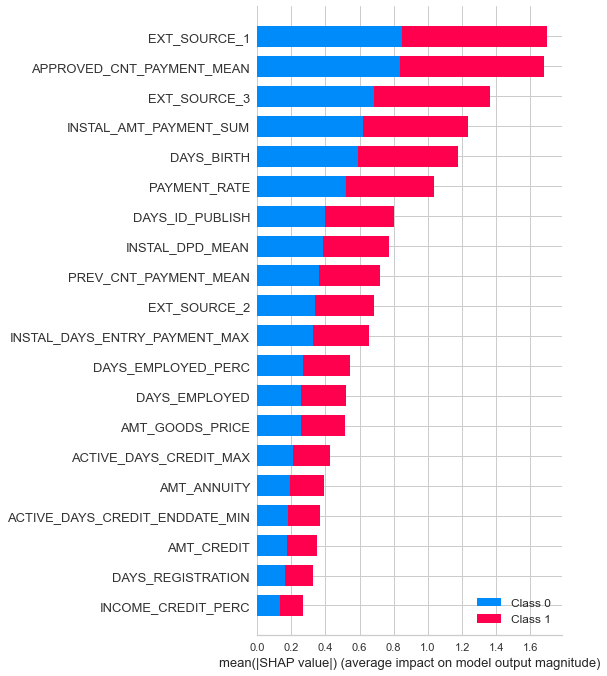

In [47]:
#data_features_test

explainer = shap.TreeExplainer(grid_imb.best_estimator_[1])
shap_values = explainer.shap_values(data_features_test[feat])
    
shap.summary_plot(shap_values, data_features_test[feat], feature_names=feat, max_display=20, show=False)

plt.savefig('./img/explain_shape.png')
plt.show()

# test

In [53]:
auc_smoke_best_params_imp(data_features_train, clf, param_grid)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


# Test de plusieurs modèles

Le modèle IterativeImputer semble bien meilleur. On va juste tester avec Pycaret pour voir si d'autres modèles peuvent avoir un meilleur résultat.

## Simp

In [ ]:
test = setup(data_features_train_simp, target="TARGET", use_gpu=True, memory="D:/Pycaret/", session_id=0, imputation_type=None, fix_imbalance=True)
best = compare_models(sort="AUC", include=['lightgbm', 'catboost', 'xgboost', 'lda'], turbo=False) 

,Description,Value
0,Session id,0
1,Target,TARGET
2,Target type,Binary
3,Original data shape,"(307507, 21)"
4,Transformed data shape,"(488007, 21)"
5,Transformed train set shape,"(395754, 21)"
6,Transformed test set shape,"(92253, 21)"
7,Numeric features,20
8,Preprocess,True
9,Imputation type,None


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lda,Linear Discriminant Analysis,0.6871,0.7344,0.6539,0.1563,0.2523,0.1402,0.1981,1.0210
xgboost,Extreme Gradient Boosting,0.8646,0.6872,0.2052,0.1887,0.1966,0.1228,0.1229,1.2000
lightgbm,Light Gradient Boosting Machine,0.8436,0.6860,0.2552,0.1763,0.2085,0.1250,0.1276,6.4310
catboost,CatBoost Classifier,0.8190,0.6827,0.3094,0.1663,0.2163,0.1244,0.1321,6.9680


Processing:   0%|          | 0/21 [00:00<?, ?it/s]

## Iterative

In [ ]:
test = setup(data_features_train_imp, target="TARGET", use_gpu=True, memory="D:/Pycaret/", session_id=0, imputation_type=None, fix_imbalance=True)
best = compare_models(sort="AUC", include=['lightgbm', 'catboost', 'xgboost', 'lda'], turbo=False) 